<a href="https://colab.research.google.com/github/shicong621/Colab/blob/main/task1_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



In [3]:
!unzip -q /content/Covid_Data_GradientCrescent.zip -d /content/data

## [20 points] Binary Classification: COVID-19 vs. Normal

In [4]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.8.0'

#### Load Image Data

In [16]:
DATA_LIST = os.listdir('/content/data/Covid_Data_GradientCrescent/two/train')
DATASET_PATH  = '/content/data/Covid_Data_GradientCrescent/two/train'
TEST_DIR =  '/content/data/Covid_Data_GradientCrescent/two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.0005 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [7]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import time

In [8]:
vgg16 = tf.keras.applications.vgg16.VGG16 (
    include_top = False,
    weights = 'imagenet',
    input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
for layer in vgg16.layers:
     layer.trainable = False

model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation = 'relu', name = 'dense_feature'))
model.add(Dense(1, activation = 'sigmoid',name = 'dense_1'))

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_feature (Dense)       (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


#### [5 points] Train Model

In [9]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

opt = Adam(learning_rate= LEARNING_RATE)
t_start = time.time()

with tf.device("GPU:0"):
  model.compile(
      loss = 'binary_crossentropy',
      optimizer = opt,
      metrics = ['accuracy']
  )
  history = model.fit(train_batches,
                      steps_per_epoch = STEP_SIZE_TRAIN,
                      validation_data = valid_batches,
                      validation_steps = STEP_SIZE_VALID,
                      epochs = NUM_EPOCHS)
  
  print("Training on GPU finished in {(time.time() - t_start) / 100} minitues")

  test_acc= model.evaluate(valid_batches)
  print(test_acc)

11
3


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/40
10/10 [==============================] - 63s 7s/step - loss: 1.7771 - accuracy: 0.5638 - val_loss: 1.4150 - val_accuracy: 0.5500
Epoch 2/40
10/10 [==============================] - 61s 6s/step - loss: 0.9144 - accuracy: 0.5213 - val_loss: 0.3777 - val_accuracy: 0.8500
Epoch 3/40
10/10 [==============================] - 61s 6s/step - loss: 0.4835 - accuracy: 0.7447 - val_loss: 0.2438 - val_accuracy: 0.9500
Epoch 4/40
10/10 [==============================] - 61s 6s/step - loss: 0.4268 - accuracy: 0.7766 - val_loss: 0.3978 - val_accuracy: 0.8500
Epoch 5/40
10/10 [==============================] - 61s 6s/step - loss: 0.2812 - accuracy: 0.8936 - val_loss: 0.1812 - val_accuracy: 0.9000
Epoch 6/40
10/10 [==============================] - 61s 6s/step - loss: 0.2484 - accuracy: 0.8936 - val_loss: 0.1274 - val_accuracy: 0.9500
Epoch 7/40
10/10 [==============================] - 61s 6s/step - loss: 0.2776 - accuracy: 0.8830 - val_loss: 0.1134 - val_accuracy: 0.9500
Epoch 8/40
10/10 [==

#### [5 points] Plot Accuracy and Loss During Training

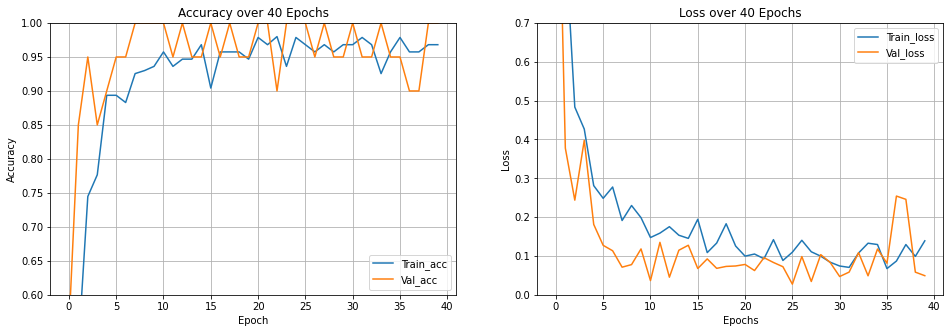

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train_acc')
plt.plot(history.history['val_accuracy'], label='Val_acc')
plt.title("Accuracy over 40 Epochs")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.6, 1])
plt.legend(loc='lower right')
plt.grid(True)

# plot loss graph
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label = 'Val_loss')
plt.title("Loss over 40 Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,0.7])
plt.legend(loc='upper right')
plt.grid(True)


#### Plot Test Results

Found 18 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


18/18 [==============================] - 11s 611ms/step
covid/nejmoa2001191_f3-PA.jpeg


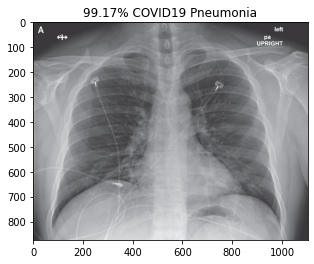

covid/nejmoa2001191_f4.jpeg


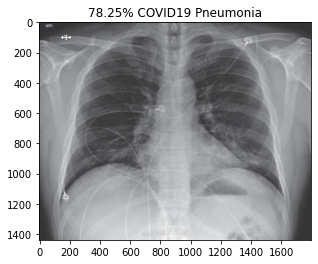

covid/nejmoa2001191_f5-PA.jpeg


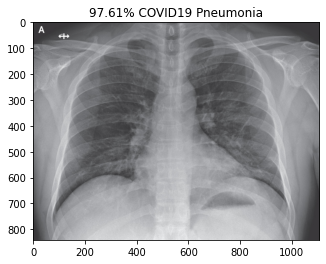

covid/radiol.2020200490.fig3.jpeg


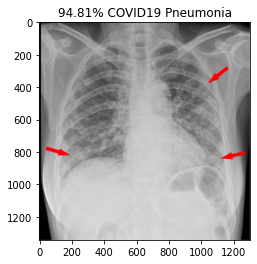

covid/ryct.2020200028.fig1a.jpeg


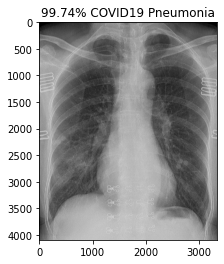

covid/ryct.2020200034.fig2.jpeg


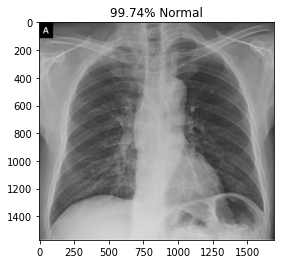

covid/ryct.2020200034.fig5-day0.jpeg


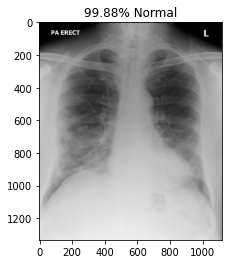

covid/ryct.2020200034.fig5-day4.jpeg


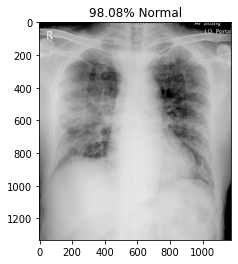

covid/ryct.2020200034.fig5-day7.jpeg


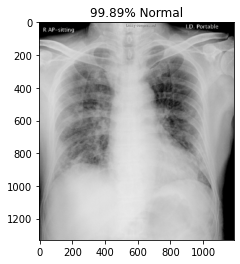

normal/NORMAL2-IM-1385-0001.jpeg


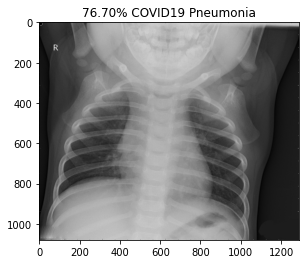

normal/NORMAL2-IM-1396-0001.jpeg


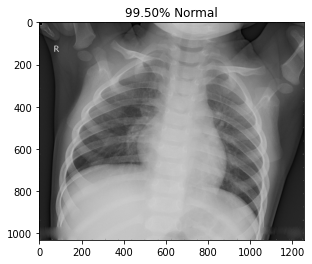

normal/NORMAL2-IM-1400-0001.jpeg


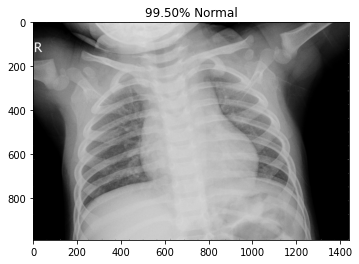

normal/NORMAL2-IM-1401-0001.jpeg


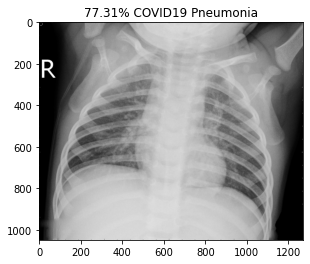

normal/NORMAL2-IM-1406-0001.jpeg


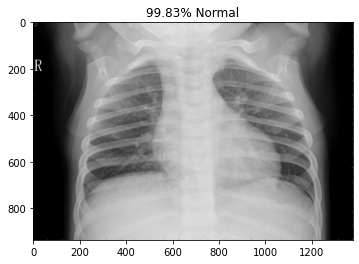

normal/NORMAL2-IM-1412-0001.jpeg


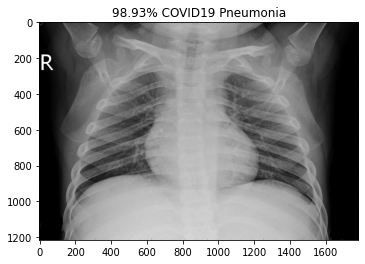

normal/NORMAL2-IM-1419-0001.jpeg


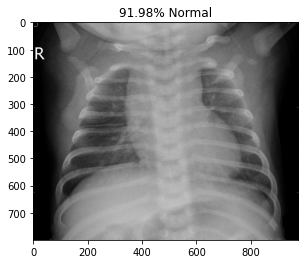

normal/NORMAL2-IM-1422-0001.jpeg


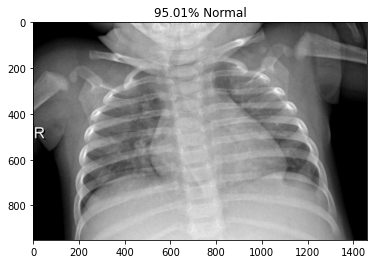

normal/NORMAL2-IM-1423-0001.jpeg


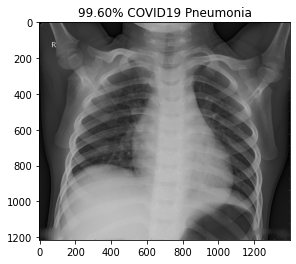

In [17]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")
eval_generator.reset()
pred = model.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 130 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


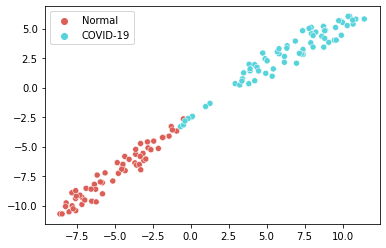

In [22]:
from sklearn.manifold import TSNE
import seaborn as sns

intermediate_layer_model = Model(inputs=model.input,
                                        outputs=model.get_layer('dense_feature').output)
tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")

vals = intermediate_layer_model.predict(tsne_data_generator)
visual = TSNE(n_components=2).fit_transform(vals)

c = tsne_data_generator.labels
labels = map(lambda x: "COVID-19" if x == 0 else "Normal", tsne_data_generator.labels)
scat=sns.scatterplot(x=visual[:,0],y=visual[:,1], hue=labels, palette=sns.color_palette("hls", 2))
handles,labels = scat.get_legend_handles_labels()
scat.legend(handles, ['Normal', 'COVID-19'])

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->